<center>
<h4></h4>
<h1><b>BERT is not pessimistic enough</b></h1>
<h2>Deep Learning - Final Project</h2>
<h3>Buket Sak, <b><u>Kascha Kruschwitz</u></b>, Ludmila Bajuk </h3>
</center>

Github link: https://github.com/kakrusch/DeepLearningFinal.git


## Introduction

The aim of our project was to test whether language models can detect whether sentence pairs are semantically similar or opposite. This topic was chosen because even LLMs seem to be unable to classify antonym relations, performing only at chance, and further struggle with several other negation-related tasks and benchmarks (Truong et al, 2023). We thus wanted to investigate this claim for ourselves.

To that end we used the CANNOT dataset (Anschütz, Lozano & Groh, 2023), a combination of several other negation datasets, thus resulting in a total of 77, 376 labeled sentence pairs. Each pair consists of a premise, some base sentence, and a hypothesis, a sentence that is either a paraphrased or a negated version of the premise. Negation here refers to both verbal negation using negative particles or affixes or "negation" via antonyms. Each sentence pair is labeled either 1 if it is negated, or 0 if it is paraphrased.


Given that the dataset provides a label of either 1 or 0, we decided on a binary classification tasks. We attempted three approaches:

1. Few-shot learning using GPT-Neo to establish a base expectation
2. Model 1: Fine-tuning the BERT base classifier provided by Keras-NLP
3. Using BERT embeddings to build a Dense NN (Model 2) and an LSTM NN (Model 3)

Overall, none of our approaches worked very well. Most models seem to perform at chance by predicting the same label every time and the one model that did learn seemed to overfit. 


## Setup

In [1]:
!pip install -q --upgrade keras-nlp
!pip install -q --upgrade keras

import numpy as np
import tensorflow as tf
import keras
import keras_nlp
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import torch
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from IPython.display import display
import pandas as pd
import random
from statistics import mean
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import time
import transformers
from transformers import AutoTokenizer, GPTNeoForCausalLM

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.5.0 which is incompatible.


2024-08-13 18:59:03.255411: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-13 18:59:03.255522: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 18:59:03.437096: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#load from google drive
#from google.colab import drive
#drive.mount('/content/drive')

#dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cannot_dataset_v1.1.tsv', sep='\t')

In [3]:
# load in kaggle

dataset = pd.read_csv('/kaggle/input/cannot-dataset-v1-1-tsv/cannot_dataset_v1.1.tsv', sep='\t')

In [4]:
# load in hulk server

# dataset = pd.read_csv('cannot_dataset_v1.1.tsv', sep='\t')

### GPU settings

(provided by Andrea)

In [5]:
# check if a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda:1") #set device
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 2 GPU(s) available.
Device name: Tesla T4


In [6]:
# see what is happening
!nvidia-smi

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Tue Aug 13 18:59:27 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
# select a specific GPU
selected_gpu = 0  # Change this to 0, 1, or 2 depending on which GPU you want to use

# Check if the specified GPU is available
if torch.cuda.is_available() and selected_gpu < torch.cuda.device_count():
    torch.cuda.set_device(selected_gpu)  # Set the selected GPU as the current device
    device = torch.device(f"cuda:{selected_gpu}")
    print(f'Using GPU {selected_gpu}.')
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    for i in range(torch.cuda.device_count()):
        print(f'GPU {i} name:', torch.cuda.get_device_name(i))
    print('Current GPU:', torch.cuda.current_device())

else:
    print('No specified GPU available, using the CPU instead.')
    device = torch.device("cpu")

Using GPU 0.
There are 2 GPU(s) available.
GPU 0 name: Tesla T4
GPU 1 name: Tesla T4
Current GPU: 0


# Data Exploration and Preprocessing

## Exploration

**Counting the labels:** We counted the labels to see if there was a somewhat even distribution of negated and non-negated sentences. As this was the case, we did not need to adjust the dataset for this.

Label 1: 39989 samples, which is 51.68% of the dataset.
Label 0: 37387 samples, which is 48.32% of the dataset.


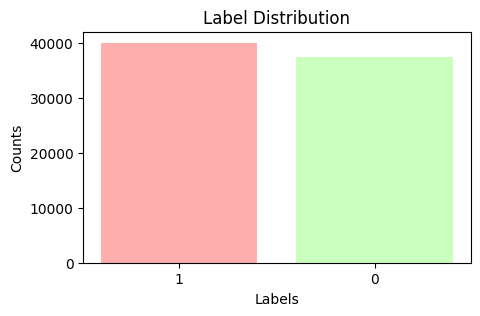

In [8]:
# load labels column from the dataset
lables = dataset["label"]

# create label count dictionary that counts each instance of a lable
label_count = {}
for i in lables:
    i = str(i) # save name as string for the graph
    if i in label_count:
        label_count[i] += 1
    else:
        label_count[i] = 1

# overall label count
total_samples = sum(label_count.values())

# print the percentage of each label from entire dataset
for label, count in label_count.items():
    percentage = (count / total_samples) * 100
    print(f"Label {label}: {count} samples, which is {percentage:.2f}% of the dataset.")


labels = list(label_count.keys()) # x-value for plot
counts = list(label_count.values()) # y-value for plot

# plot the distribution of each label
plt.figure(figsize=(5, 3))
plt.bar(labels, counts, color=['#ffadad', '#caffbf'])
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Label Distribution')
plt.show()

**Shuffle the data:** We were not shure whether the dataset was in a specific order based on which sub-dataset the sentences came from. Thus, we shuffeled the data to get a random selection of sentences between the training and test samples. The original indices (row names) were kept to be referenced later on.


In [9]:
# random seed for reproducibility
random_seed = 42
random.seed(random_seed)

# Shuffle the rows but keep original indices
dataset = dataset.sample(frac=1, random_state=random_seed)

# convert to dataframe to print the first 10 rows of the df but looking pretty
df = pd.DataFrame(dataset)
display(df.head(10))

,premise,hypothesis,label
26404,In November 2011 European Court of Justice ref...,In November 2011 European Court of Justice mai...,1
7481,The city is designated as a Million Plus Urban...,The city is designated as an Under a Million U...,1
36957,There are protections against discrimination b...,Danish law includes protections against discri...,0
52424,But it can be declared deprecated : A coded ch...,But it can be declared deprecated : A coded ch...,1
54858,I'm not bad today.,I'm bad today.,1
51856,The magnetic moment of the antineutron is the ...,The magnetic moment of the antineutron is the ...,1
53737,Conferences and seminars were conducted by him.,He was also instrumental in conducting confere...,0
24145,The only way the movie could be redeemed was a...,The only possible way this movie could be rede...,0
53162,"Lastly, research continues in the other domain...",Research continues in the other areas of the s...,0
62465,The material's efficiency was partially reduce...,The material's efficiency was increased by sev...,1


**Prediction sentences for quality evaluation:** As the dataset consists of both negation using verbal negation (eg. using 'nt or not) and antonyms, we extracted example sentences of either type, to see if our models are better at one task then another.

The data consists of:
 - 5 sentence pairs with negation using antonyms
 - 5 sentence pairs with verbal negations
 - 10 paraphrased sentence pairs


In [10]:
# get row names (original indices of target sentences)
antonym_row_names = [50487, 41715, 32427, 48323, 27068]
negation_row_names = [57658, 37518, 14465, 42008, 560]
paraphrased_row_names = [6543, 51922, 16802, 66953, 24641, 14896, 20770, 70327, 34157, 64309]

# get the indice of these sentences after shuffling the dataset
def get_df_index(row_names):
  index_list = []
  for i in row_names:
    index_list.append(dataset.index.get_loc(dataset.loc[i].name))
  return index_list

# these indices can now be used to access the sentences after preprocessing
antonym_index = get_df_index(antonym_row_names)
negation_index = get_df_index(negation_row_names)
paraphrased_index = get_df_index(paraphrased_row_names)


# Print the results
print("Antonym Indices:")
print(f"{'Original':<15} {'Shuffled':<15}")
for original, new in zip(antonym_row_names, antonym_index):
    print(f"{original:<15} {new:<15}")

print("\nNegation Indices:")
print(f"{'Original':<15} {'Shuffled':<15}")
for original, new in zip(negation_row_names, negation_index):
    print(f"{original:<15} {new:<15}")

print("\nParaphrased Indices:")
print(f"{'Original':<15} {'Shuffled':<15}")
for original, new in zip(paraphrased_row_names, paraphrased_index):
    print(f"{original:<15} {new:<15}")

Antonym Indices:
Original        Shuffled       
50487           2884           
41715           52987          
32427           71555          
48323           11800          
27068           44436          

Negation Indices:
Original        Shuffled       
57658           34924          
37518           18576          
14465           51686          
42008           31695          
560             69603          

Paraphrased Indices:
Original        Shuffled       
6543            10711          
51922           7804           
16802           54667          
66953           32607          
24641           52258          
14896           22606          
20770           2446           
70327           33520          
34157           76091          
64309           75430          


**Exploring the sentence length distribution:**
Using naïve white-space tokenization, the lengths of the sequences were counted.

We then decided on a sentence length of about 16 tokens as input to our models, i.e. an overall length of 32 tokens, including both sentences as well as the special tokens. As we wanted to preserve as much of the sentences as possible we decided to opt for a length that relied on padding more than truncation.

The distribution of the dataset is displayed in the graph below. It may be worth noting that while the distribution for the premise and hypothesis columns are exactly the same, the individual sentences for each pair are not.

Analysis of the 'premise' column:
Minimum length of sequences: 1
Maximum length of sequences: 58
Average length of sequences: 10.69
Number of sequences < 16 tokens: 72317
Percentage of sequences < 16 tokens: 93.46%
Number of sequences >= 16 tokens: 5059
Percentage of sequences >= 16 tokens: 6.54%


Analysis of the 'hypothesis' column:
Minimum length of sequences: 1
Maximum length of sequences: 58
Average length of sequences: 10.69
Number of sequences < 16 tokens: 72317
Percentage of sequences < 16 tokens: 93.46%
Number of sequences >= 16 tokens: 5059
Percentage of sequences >= 16 tokens: 6.54%




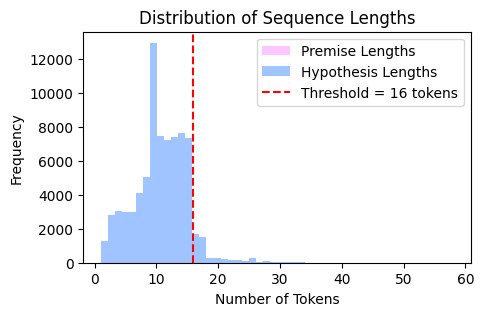

In [11]:
# Define the max_len function - rough approximation because split by whitespace
def max_len(column):
    lent = [len(str(i).split(" ")) for i in dataset[column]]
    return min(lent), max(lent), np.mean(lent)


def analyze_sequence_lengths(dataset, column, threshold=16):
    # Using the max_len function to get the min, max, and average lengths
    min_len, max_len_val, avg_len = max_len(column)

    # Calculate the lengths of all sequences
    sequence_lengths = [len(str(i).split(" ")) for i in dataset[column]]

    # Count how many sequences are longer than or equal to the threshold
    longer_sequences = [length for length in sequence_lengths if length >= threshold]
    percentage_longer_sequences = (len(longer_sequences) / len(sequence_lengths)) * 100

    # Count how many sequences are shorter than  to the threshold
    shorter_sequences = [length for length in sequence_lengths if length < threshold]
    percentage_shorter_sequences = (len(shorter_sequences) / len(sequence_lengths)) * 100

    # Print the results
    print(f"Analysis of the '{column}' column:")
    print(f"Minimum length of sequences: {min_len}")
    print(f"Maximum length of sequences: {max_len_val}")
    print(f"Average length of sequences: {avg_len:.2f}")
    print(f"Number of sequences < {threshold} tokens: {len(shorter_sequences)}")
    print(f"Percentage of sequences < {threshold} tokens: {percentage_shorter_sequences:.2f}%")
    print(f"Number of sequences >= {threshold} tokens: {len(longer_sequences)}")
    print(f"Percentage of sequences >= {threshold} tokens: {percentage_longer_sequences:.2f}%")
    print("\n")

    return sequence_lengths

# Analyzing the 'premise' and 'hypothesis' columns for length
premise_lengths = analyze_sequence_lengths(dataset, "premise")
hypothesis_lengths = analyze_sequence_lengths(dataset, "hypothesis")


# plot the distribution
plt.figure(figsize=(5, 3))

plt.hist(premise_lengths, bins=50, alpha=1, label='Premise Lengths', color="#ffc6ff")
plt.hist(hypothesis_lengths, bins=50, alpha=1, label='Hypothesis Lengths', color = "#a0c4ff")

# plot sequence length threshols
plt.axvline(x=16, color='red', linestyle='--', label='Threshold = 16 tokens')

plt.title('Distribution of Sequence Lengths')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Pre-processing


For the preprocessing we used the Bert preprocessor provided by Keras. As mentioned before we set the maximum sequence length to 32 tokens, which includes the premise and hypothesis, as well as the special tokens added by the preprocessor. The sentences were tokenized and concatenated, with a [SEP] token being added in between to separate them. [CLS] and [PAD] tokens are also added by the preprocessor. Examples for this are given in the output of the second cell in this section.

The preprocessor automatically creates 3 types of embeddings for each sequence:

1. "token_ids": numerically represent each word/token

2. "segment_ids": whether a token belongs to the premise or the hypothesis
    
3. "padding_mask": indicate which tokens are [PAD], to ignore those later

In [12]:
#tokenizing and padding
tokenizer = keras_nlp.models.BertTokenizer.from_preset("bert_base_en_uncased")

# load the preprocessor
# round_robin truncates from beginning and end of sequences equally
preprocessor = keras_nlp.models.BertPreprocessor.from_preset(
    "bert_base_en_uncased", sequence_length=32, truncate="round_robin")

Attaching 'model.safetensors' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'model.safetensors.index.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.txt' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'model.safetensors' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'model.safetensors.index.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle 

In [13]:
# to create multi-sentence embeddings extract premise and hypothesis columns
first = tf.constant([dataset["premise"][i] for i in range(len(dataset))])
second = tf.constant([dataset["hypothesis"][i] for i in range(len(dataset))])

# run the preprocessor, it concatenates with [SEP] and adds [PAD] and [CLS]
preprocessed_data = preprocessor((first, second))

# check how the padding and special token insertion works by decoding the encoding
decoded_text = tokenizer.detokenize((preprocessed_data["token_ids"])[:8])
print("Decoded Text (First 8 Samples):")
for i, text in enumerate(decoded_text.numpy()):
    print(f"Sample {i+1}: {text.decode('utf-8')}\n")

Decoded Text (First 8 Samples):
Sample 1: [CLS] the joint typhoon warning center ( jtwc ) also issued warnings in an [SEP] the joint typhoon warning center ( jtwc ) only issued warnings in [SEP]

Sample 2: [CLS] commercial dnp is used as an antiseptic and as a non - [SEP] commercial dnp is unable to be utilized as an antiseptic or [SEP]

Sample 3: [CLS] spinal locks and cervical locks are allowed and mandatory in ibjjf brazilian [SEP] spinal locks and cervical locks are forbidden in ibjjf brazilian ji [SEP]

Sample 4: [CLS] dredgers excavate the sediment using mechanical or hydraulic methods or a combination of both [SEP] the dredgers use either mechanical or hydraulic methods . [SEP]

Sample 5: [CLS] in 2014 , nextgen earns klas top performance honors for ambula [SEP] in 2014 , nextgen fails to achieve klas top performance honors for [SEP]

Sample 6: [CLS] on june 22 , 2009 , the sec also filed civil fraud charges . [SEP] on june 22 , 2009 , the sec kept itself from filing civil fraud

**Predictor embeddings:** Extract the embeddings for the predictor sentences, as well as their target labels.

In [14]:
# concatenate prediction original and new indices
pred_indices = antonym_index + negation_index + paraphrased_index
pred_rows = antonym_row_names + negation_row_names + paraphrased_row_names

# get the preprocessor output for the prediction sentences
pred_features = {
    "token_ids": tf.stack([preprocessed_data['token_ids'][i] for i in pred_indices]),
    "segment_ids": tf.stack([preprocessed_data['segment_ids'][i] for i in pred_indices]),
    "padding_mask": tf.stack([preprocessed_data['padding_mask'][i] for i in pred_indices]),
}

# also get the prediction labels from the dataset
pred_labels = list(dataset.loc[[i for i in pred_rows], "label"])

# Print headers
print(f"{'Shuffled Index':<15} {'Original Row Name':<20} {'Label':<5}")
# Print each row's details
for shuffled_index, original_row, label in zip(pred_indices, pred_rows, pred_labels):
    print(f"{shuffled_index:<15} {original_row:<20} {label:<5}")


Shuffled Index  Original Row Name    Label
2884            50487                1    
52987           41715                1    
71555           32427                1    
11800           48323                1    
44436           27068                1    
34924           57658                1    
18576           37518                1    
51686           14465                1    
31695           42008                1    
69603           560                  1    
10711           6543                 0    
7804            51922                0    
54667           16802                0    
32607           66953                0    
52258           24641                0    
22606           14896                0    
2446            20770                0    
33520           70327                0    
76091           34157                0    
75430           64309                0    


**Extracting labels** was done in different ways, to be compatible with the different models.

The output of Model 1 are two values, one for each label, as is common for multi-class classification. It thus requires one-hot encoded labels as input. Model 2 and 3 only have a single output node and generate a single value between 0 and 1, and thus the input does not require further preprocessing.

In [15]:
# get labels from dataset as a list
labels = list(dataset["label"])

# print to see that is works
print("Original Labels (from index 100 to 200):")
print(labels[100:200])

# preprocess for one-hot encoding (set to 0 and 1) - not necessary but just in case
labels_01 = np.unique(np.array(labels), return_inverse=True)[1]
# one-hot encode
labels_01  = to_categorical(labels_01)

# preprocess for binary classification with single output
labels_02 = np.asarray(labels)

Original Labels (from index 100 to 200):
[0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0]


**Train-Test Split**

We decided on a split of 85:15, because the dataset is not very big and included a lot of rare words, so we wanted to give it a fighting chance. As the data was shuffled previously, the data is now simply split linearly.

Aside from a feature collection for the training and test data, the full dataset's features are also saved, as they are needed for Model 3.

In [16]:
# set test-train split to 15:85
training_samples = (len(labels) * 85)//100

# get split for all three embedding vectors
x_train_token_ids = preprocessed_data['token_ids'][:training_samples]
x_train_segment_ids = preprocessed_data["segment_ids"][:training_samples]
x_train_padding_mask = preprocessed_data["padding_mask"][:training_samples]

# also get split for labels for both model types
y_train_01 = labels_01[:training_samples]
y_train_02 = labels_02[:training_samples]

# use remaining sentences and labels for testing
x_test_token_ids = preprocessed_data['token_ids'][training_samples:]
x_test_segment_ids = preprocessed_data["segment_ids"][training_samples:]
x_test_padding_mask = preprocessed_data["padding_mask"][training_samples:]

y_test_01 = labels_01[training_samples:]
y_test_02 = labels_02[training_samples:]

# get shape of the results
print(f"Shape of Token ID training data: {x_train_token_ids.shape}")
print("Shape of Model 1's label tensor:", y_train_01.shape)
print("Shape of Model 2's label tensor:", y_train_02.shape)

# get embeddings bundled again for single model input
x_train_features = {
    "token_ids": x_train_token_ids,
    "segment_ids": x_train_segment_ids,
    "padding_mask": x_train_padding_mask,
}

x_test_features = {
     "token_ids": x_test_token_ids,
    "segment_ids": x_test_segment_ids,
    "padding_mask": x_test_padding_mask,
}

# get bundle for entire dataset to be used in model 2
features = {
    "token_ids": preprocessed_data['token_ids'],
    "segment_ids": preprocessed_data["segment_ids"],
    "padding_mask": preprocessed_data["padding_mask"],
}

Shape of Token ID training data: (65769, 32)
Shape of Model 1's label tensor: (65769, 2)
Shape of Model 2's label tensor: (65769,)


# **FEW SHOT TRAINING GPT-Neo**

The first step in our investigation was attempting few-shot learning using GPT-Neo, a version of GPT-3 that is trained for next token prediction. We did this to establish a baseline, to see how optimistic we should be about the other models we were training.

After loading the model and it's tokenizer, we provided a prompt and some classification examples from the dataset to the model. We then use this to predict the labels for all our prediction sentences.

In [17]:
# Load the pre-trained GPT-Neo model and tokenizer
model_name = "EleutherAI/gpt-neo-1.3B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = GPTNeoForCausalLM.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.31G [00:00<?, ?B/s]

In [18]:
classification_examples = """
Classify the hypothesis as a negated (1) or non-negated (0) version of the premise. Examples:
Premise: This is a bad idea.
Hypothesis: This is not a good idea.
Label: 1
###
Premise: It's not healthy.
Hypothesis: It's unhealthy.
Label: 0
###
Premise: No one has a set of principles to live by.
Hypothesis: Everyone has a set of principles to live by.
Label: 1
###
Premise: The cat was sitting on the mat.
Hypothesis: The cat sat on the mat.
Label: 0
###
Premise:  I saw nothing at all.
Hypothesis: I didn't see anything.
Label: 0
###
Premise: Both do good jobs and are quite amusing.
Hypothesis: Both do good jobs and aren't quite amusing.
Label: 1
###
Premise: Griffon has been banned from being publicly traded since 1961.
Hypothesis: Griffon has been publicly traded since 1961.
Label: 1
###
Input: The plant will probably die if it hasn't had enough time to regenerate.
Hypothesis: If the plant has not had time to sufficiently regenerate it will probably perish.
Label: 0
###
Input: It's not uneasy to explain.
Hypothesis: It's not easy to explain.
Label: 1
###
Input: After retiring in 1954, Yee worked for a long time with Harrington.
Hypothesis: After retiring in 1954, Yee worked with Harrington nearly every day.
Label: 0
"""


In [19]:
def classify_neg(classification_examples, premise, hypothesis):
    # prompt including preset examples and the new sample
    prompt = f"{classification_examples}\n\n{premise}\n\n{hypothesis}\n\n Label:"

    # Tokenize the prompt
    input_ids = tokenizer.encode(prompt, return_tensors="pt")

    # Generate text output
    output = model.generate(
        input_ids,
        max_length=len(input_ids[0]) + 50,
        num_return_sequences=1,
        temperature=0.7, # make it a bit more random
        pad_token_id=tokenizer.eos_token_id
    )

    # Decode the generated text
    generated_classification = tokenizer.decode(output[0], skip_special_tokens=True)

    # Extract the classification result from the text
    start_idx = generated_classification.find("Label:") + len("Label:")
    end_idx = generated_classification.find("###", start_idx)
    if end_idx == -1:
        end_idx = None
    classification_result = generated_classification[start_idx:end_idx].strip()

    return classification_result

As mentioned before, we tested the model using the prediction sentences. We then generated a confusion matrix to display the models perormance. As we can see from comparing the target and predicted labels, the model does not perform very well. GPT always predicts the label 1 ("Negated"), such that half the time it generates true positive examples, and the other half it generates false positive examples.

In [20]:
# run the model on each of the prediction sentences
premises = list(dataset.loc[[i for i in pred_rows], "premise"])
hypothesees = list(dataset.loc[[i for i in pred_rows], "hypothesis"])

gpt_pred = []
for prem, hyp in zip(premises, hypothesees):
    answer = classify_neg(classification_examples, prem, hyp)
    gpt_pred.append(answer)

# display the output predictions
print(pred_labels)
print(gpt_pred)

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:540: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1']


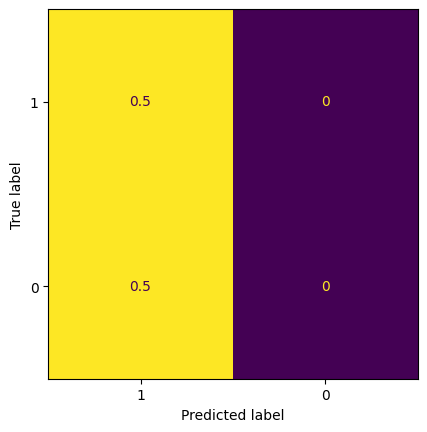

In [21]:
#Create confusion matrix in percentages
result = confusion_matrix(pred_labels, [int(i) for i in gpt_pred], normalize='pred', labels=[1,0] )

# visualize confusion matrix with sklearn metrics
# define matrix and labels
result_display = metrics.ConfusionMatrixDisplay(confusion_matrix = result, display_labels = ["1", "0"])

# display matrix without the colorbar for neatness
result_display.plot(colorbar=False)
plt.show()

# **MODEL 1**


The second attempt at classification was made by fine-tuning the BERT base classifier provided by Keras-nlp. One of the tasks BERT is trained on is Next Sentence Prediction, such that given two sentences, it needs to predict whether the second sentence follows from the first. Our current problem is similar, in that the model is tasked with detecting whether sentence 1 stands in a certain relation to sentence 2. Thus, we were hoping that the model by itself could use semantic information from the embeddings to learn negation. The given code was inspired by Mishra (2023).


In [22]:
# load normal BERT classifier for english including the existing weights
# preprocessor = None, because it was done manually before
# in this model, binary classification requires 2 classes
classifier = keras_nlp.models.BertClassifier.from_preset(
    "bert_base_en_uncased", preprocessor = None,
    num_classes=2, load_weights=True,  trainable=True)

Attaching 'model.safetensors' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'model.safetensors.index.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'task.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'model.safetensors' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'model.safetensors.index.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'met

**Training the model**

The model was compiled using binary crossentropy and the Adam optimizer. Different optimizers as well as both higher and lower learning rates did not improve model performance. Neither did different batch sizes or training for more epochs.

In [23]:
#Compiling the model for binary classification, using manual learning rate
classifier.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=['accuracy'])

# Training BERT and show the training progress
history_01 = classifier.fit(
    x_train_features, y_train_01,
    epochs=5, batch_size=64, validation_split=0.2, verbose = 1)

Epoch 1/5


I0000 00:00:1723576133.397043      85 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1723576133.472925      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


823/823 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.5042 - loss: 0.7936

W0000 00:00:1723576502.493921      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723576506.933458      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


823/823 ━━━━━━━━━━━━━━━━━━━━ 512s 481ms/step - accuracy: 0.5042 - loss: 0.7936 - val_accuracy: 0.5176 - val_loss: 1.0539
Epoch 2/5


W0000 00:00:1723576529.060080      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


823/823 ━━━━━━━━━━━━━━━━━━━━ 301s 366ms/step - accuracy: 0.5011 - loss: 0.7643 - val_accuracy: 0.5176 - val_loss: 1.0359
Epoch 3/5
823/823 ━━━━━━━━━━━━━━━━━━━━ 301s 366ms/step - accuracy: 0.4999 - loss: 0.7618 - val_accuracy: 0.5176 - val_loss: 1.0088
Epoch 4/5
823/823 ━━━━━━━━━━━━━━━━━━━━ 300s 365ms/step - accuracy: 0.4991 - loss: 0.7647 - val_accuracy: 0.5176 - val_loss: 0.9762
Epoch 5/5
823/823 ━━━━━━━━━━━━━━━━━━━━ 300s 364ms/step - accuracy: 0.5009 - loss: 0.7628 - val_accuracy: 0.5176 - val_loss: 1.0291


**Evaluation on the Test Set**

In [24]:
#evaluation
test_ev_01 = classifier.evaluate(x_test_features, y_test_01)

  3/363 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.5642 - loss: 0.9442

W0000 00:00:1723577757.286211      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


363/363 ━━━━━━━━━━━━━━━━━━━━ 23s 57ms/step - accuracy: 0.5170 - loss: 1.0303


W0000 00:00:1723577777.794025      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


**Plotting Accuracy and Loss**


In [25]:
# define function for plotting accuracy and loss for training, validation and test data
def plot_training_history(history, test_metrics):

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(accuracy) + 1) # get maximum epochs to plot test data there

    # Plotting test, training & validation accuracy
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy, 'r', label='Training accuracy')
    plt.plot(epochs_range, val_accuracy, 'b', label='Validation accuracy')
    plt.plot(max(epochs_range), test_metrics[1], 'go', label='Test acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting test, training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'r', label='Training loss')
    plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
    plt.plot(max(epochs_range), test_metrics[0], 'go', label='Test acc')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


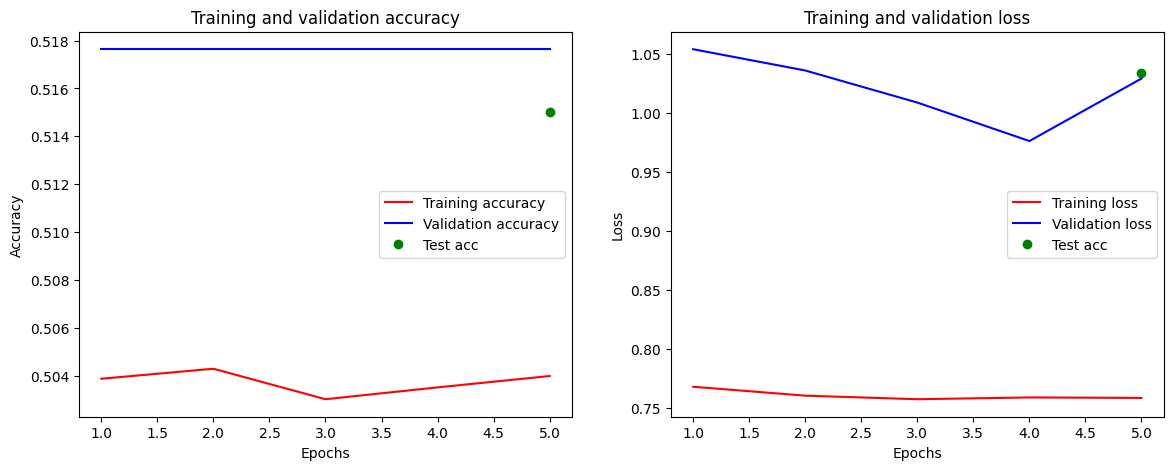

In [26]:
# apply plot to the first model
plot_training_history(history_01, test_ev_01)

**Predictions**

In [27]:
# use model to make predictions on the target sentences
pred_predictions = classifier.predict(pred_features)
pred_labels_array = np.array(pred_labels)
print(pred_labels_array)

# BERT model output is raw numbers for each class
# scaled to probabilities using softmax
def softmax(x):
    return np.exp(x) / np.exp(x).sum(axis=0) # axis=1  !!!

# Get the class predictions with maximum probabilities
predictions1 = softmax(pred_predictions)

# Print the class predictions with maximum probabilities
predicted_classes1 = np.argmax(predictions1, axis=1)
print("Predicted labels:", predicted_classes1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Predicted labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


W0000 00:00:1723577786.779574      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


**Classification Report**


In [28]:
# from Andrea - define function to get detailed results
# use metrics from sklearn
def evaluate_classification(pred_labels, predicted_classes):

    # Calculating accuracy
    accuracy = accuracy_score(pred_labels, predicted_classes)

    # Calculating macro-F1 score
    macro_f1 = f1_score(pred_labels, predicted_classes, average='macro')

    # Generating a detailed classification report
    detailed_report = classification_report(pred_labels, predicted_classes)

    # Printing the results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro-F1 Score: {macro_f1:.4f}")
    print("---------------------------------") #??????
    print("Detailed Classification Report:")
    print(detailed_report)

    # Returning results as a dictionary
    #return {
     #   'accuracy': accuracy,
      #  'macro_f1': macro_f1,
       # 'classification_report': detailed_report
    #}

In [29]:
# apply evaluation function
evaluate_classification(pred_labels, predicted_classes1)

Accuracy: 0.5000
Macro-F1 Score: 0.3333
---------------------------------
Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.50      1.00      0.67        10

    accuracy                           0.50        20
   macro avg       0.25      0.50      0.33        20
weighted avg       0.25      0.50      0.33        20



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Confusion** **matrix**

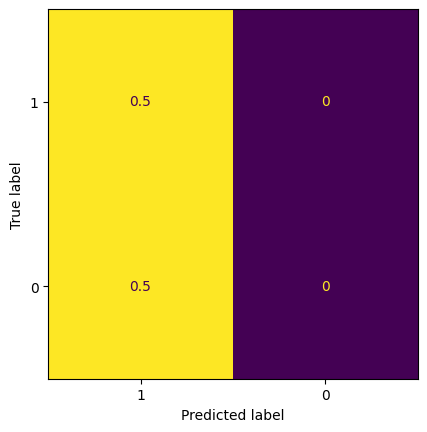

In [30]:
#Create confusion matrix
result1 = confusion_matrix(pred_labels_array, predicted_classes1, normalize='pred', labels=[1,0] )

# display matrix
result_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix = result1, display_labels = ["1", "0"])
result_display1.plot(colorbar=False)
plt.show()

**Results**

Plotting the accuracy indicated the the model  performance is at chance (around 0.5 accuracy). When looking at the predictions the model makes, we can see that the model, like the GPT model, only selects a single category each time and as the data is relatively balanced, this results in it being correct half the time. In this version of the notebook the model always selects 1, but sometimes the model also defaults to 0.

This is also illustrated in the classification report, where the model has a precision of precision of 0.5 and recall 0f 1.0 for label 1, as it is correct for this label half the time and correctly predicts all instances of 0 to be 0. However, both precision and recall for 0 are at 0.0, as this label is never guessed. Thus, the overall Macro-F1 Score is only 0.3333. 

All these results are illustrated in the confusion matrix, which shows 50% True Positives and 50% False Positives. Thus overall, the model performs at chance and thus poorly.

# **MODEL 2 & 3**

Models 2 and 3 use BERT embeddings as input for a regular dense and an LSTM model respectively, to see if the BERT classification model can be improved if given more depth or a more complex structure.

### Embedding

To generate dense embeddings we use the Keras BERT Backbone with BERT-base-uncased. This is essentially the same as the BERT model used for Model 1, except without the classification head. Further, we generate the embeddings with a pre-trained BERT model, i.e. with frozen weights. BERT then generates two types of embeddings, each with a standard vector size of 768 dimensions.

The first type are sequential embeddings which are separate vector representations of each word, resulting in a 2D embedding for each sequence and a 3D representation of all the data. This is suitable input for the LSTM, as this sequentially processes words and can take word order into account.

The second type of embeddings are pooled embeddings, which are a single vector for each sequence that captures the overall meaning of that sequence, resulting in a 2D representation of the data. These embeddings are suitable input for a dense network, where all the input sequence must be processed at once.

Thus, for our two models, we extracted both pooled and sequential embeddings and used them as input for Model 2 and 3 respectively.


In [31]:
# load BERT embedder using the GPU, with weights and not trainable
# preprocessor is false, as it was done manually before
with tf.device('/device:GPU:0'):  # Replace '0' with the desired GPU
    embedder = keras_nlp.models.BertBackbone.from_preset(
        "bert_base_en_uncased",  load_weights=True, preprocessor=None, trainable=False
    )

Attaching 'model.safetensors' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'model.safetensors.index.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/bert/keras/bert_base_en_uncased/2' to your Kaggle notebook...


In [32]:
# get time it takes to embed
start_time = time.time()

# embedding is done in batches to not overload the GPU
batch_size = 32
seq_embeddings = []
pool_embeddings = []
with tf.device('/device:GPU:0'): # use the gpu
    for i in range(0, len(features["token_ids"]), batch_size):
        batch_features = {
            "token_ids": features["token_ids"][i: i + batch_size],
            "segment_ids": features["segment_ids"][i: i + batch_size],
            "padding_mask": features["padding_mask"][i: i + batch_size],
        }
        batch_embeddings = embedder(batch_features)
        # get both sequence and pooled embeddings
        # .extends flattens batches back into single row
        seq_embeddings.extend(batch_embeddings['sequence_output'])
        pool_embeddings.extend(batch_embeddings['pooled_output'])

# Record the end time
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")


Elapsed time: 527.40 seconds


In [33]:
# get some information to see if it worked
print("Number of Sequence Embeddings:", len(seq_embeddings))
#print(seq_embeddings.shape)
print("Length of y_train_02:", len(y_train_02))
print("Number of Token IDs in Features:", len(features["token_ids"]))
print("\nSample of Token IDs (first 2):")
print(features["token_ids"][:2])
print("\nSample Data (first 2 sequences):")
print(seq_embeddings[:2])

Number of Sequence Embeddings: 77376
Length of y_train_02: 65769
Number of Token IDs in Features: 77376

Sample of Token IDs (first 2):
tf.Tensor(
[[  101  1996  4101 15393  5432  2415  1006  1046  2102 16526  1007  2036
   3843 16234  1999  2019   102  1996  4101 15393  5432  2415  1006  1046
   2102 16526  1007  2069  3843 16234  1999   102]
 [  101  3293  1040 16275  2003  2109  2004  2019  3424  3366 20746  1998
   2004  1037  2512  1011   102  3293  1040 16275  2003  4039  2000  2022
  12550  2004  2019  3424  3366 20746  2030   102]], shape=(2, 32), dtype=int32)

Sample Data (first 2 sequences):
[<tf.Tensor: shape=(32, 768), dtype=float32, numpy=
array([[-0.9500362 , -0.02559358, -0.42308766, ..., -0.8528032 ,
         0.09129428,  0.07362685],
       [-0.06119687, -0.11673031, -0.4369478 , ...,  0.09962112,
         1.2962011 ,  0.13774018],
       [ 0.16016704, -0.19487922,  0.3218239 , ..., -0.12377342,
         0.19195   , -0.5271513 ],
       ...,
       [-0.01281314,  0.408

Issues here: It is worth noting that for the LSTM layer, we were not able to train the model on the full training dataset, because the GPU on Kaggle ran out of memory. The model provided here is thus trained on only 40000 out of around 60000 sentences, However, this seemed to only be the case when running the full model in Kaggle, but not when running it in Colab. Kaggle seemed to be storing certain information on the GPU when loading the preprocessor at the beginning of this notebook (which, to my knowledge, it should not be doing). Furtunately, when training the model on the full dataset, the results were not largely different.

In [34]:
# reshape the pooled embeddings to be suitable input
reshaped_pool_embeddings = tf.reshape(pool_embeddings, shape=(-1, 768))

# get training/test split from pooled embeddings
x_train_02 = reshaped_pool_embeddings[:training_samples]
x_test_02 = reshaped_pool_embeddings[training_samples:]

# also get training/test split for model 3 from sequential
x_train_03 = seq_embeddings[:training_samples]
x_test_03 = seq_embeddings[training_samples:]


# 65769 is full amount, but GPU on Kaggle runs out of memory if using full length 
# thus increase if possible, but reduce if necessary (30000 ideally, anything lower is not super good)
train_03_len = 50000

with tf.device('/device:GPU:1'): # switch to other GPU to not overload first one
    # generate a 3D tensor from the list of sequence tensors
    #x_train_03 = tf.stack(x_train_03)  # full set
    x_train_03 = tf.stack(x_train_03[:train_03_len])
    x_test_03 = tf.stack(x_test_03)

print(x_train_03.get_shape())

# get labels for train and test data
#y_train_03 = y_train_02  # full set
y_train_03 = y_train_02[:train_03_len]
y_test_03 = y_test_02


# get embedding of both types for the prediction sentences
x_pred_02 = tf.gather(reshaped_pool_embeddings,
                indices=pred_indices)

x_pred_03 = [seq_embeddings[x] for x in pred_indices]
x_pred_03 = tf.stack(x_pred_03)

(50000, 32, 768)


### Model 2

Model 2 is a dense model with five hidden layers and one output layer and the same optimizer and loss function as Model 1. The model contains as many layers as it does in an attempt to improve model performance. Unfortunately, it did not, and neither did alternating the amount of nodes in both the smaller and larger models. Here the validation split is smaller in an attempt to provide the model with more data, which also did not signifcantly improve the model.

In [35]:
# build sequential model of many dense layers
model_02 = Sequential(name='Model_02')
model_02.add(layers.Dense(256, activation='relu', input_shape=(768,)))
model_02.add(layers.Dense(256, activation='relu'))
model_02.add(layers.Dense(128, activation='relu'))
model_02.add(layers.Dense(64, activation='relu'))
model_02.add(layers.Dense(16, activation='relu'))
# single output node with sigmoid activation for probablities
model_02.add(layers.Dense(1, activation='sigmoid'))

# compile model with adam optimizer and binary crossentropy loss
model_02.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_02.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Model_02"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,865 (1.16 MB)

 Trainable params: 304,865 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# train model using the established training set, with 10% used for validation
# parameters: 50 epochs, batches of 32
history_02 = model_02.fit(x_train_02, y_train_02,
                            epochs=50,
                            batch_size=32,
                            validation_split=0.1)

Epoch 1/50
  80/1850 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5162 - loss: 0.7028

W0000 00:00:1723578364.370799      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1850/1850 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5142 - loss: 0.6953

W0000 00:00:1723578369.378393      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723578369.828499      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1850/1850 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.5142 - loss: 0.6953 - val_accuracy: 0.5171 - val_loss: 0.6926
Epoch 2/50
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5198 - loss: 0.6927 - val_accuracy: 0.5170 - val_loss: 0.6925
Epoch 3/50
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5198 - loss: 0.6924 - val_accuracy: 0.5170 - val_loss: 0.6926
Epoch 4/50
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5196 - loss: 0.6925 - val_accuracy: 0.5170 - val_loss: 0.6926
Epoch 5/50
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5187 - loss: 0.6925 - val_accuracy: 0.5170 - val_loss: 0.6925
Epoch 6/50
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5174 - loss: 0.6927 - val_accuracy: 0.5170 - val_loss: 0.6926
Epoch 7/50
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5200 - loss: 0.6924 - val_accuracy: 0.5170 - val_loss: 0.6926
Epoch 8/50
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5165 - loss: 0.6927 - val_accurac

**Evaluation on the Test Set**

In [37]:
# evaluate on test set
test_ev_02 = model_02.evaluate(x_test_02, y_test_02)

363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5170 - loss: 0.6926


W0000 00:00:1723578575.952646      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


**Plotting Accuracy and Loss**

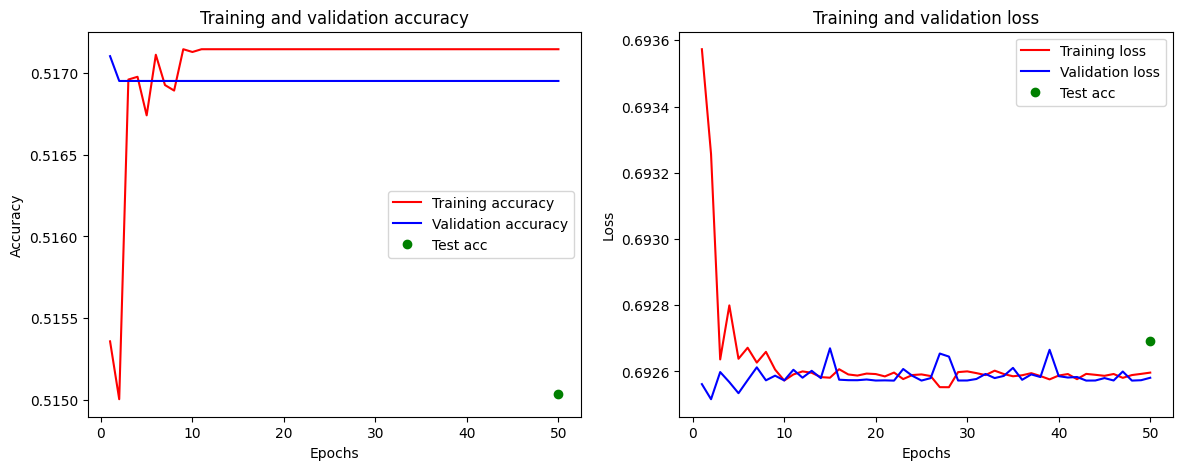

In [38]:
# apply plotting function from before
plot_training_history(history_02, test_ev_02)

**Predictions**

In [39]:
# make prediction for set sentences
pred_predictions2 = model_02.predict(x_pred_02)
pred_labels_array = np.array(pred_labels)

# output is already a probability via sigmoid, so pick most probable
predicted_classes2 = [1 if prob[0] >= 0.5 else 0 for prob in pred_predictions2]
predicted_classes2_array = np.array(predicted_classes2)

# print target and predicted lables
print(pred_labels_array)
print(predicted_classes2_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


W0000 00:00:1723578582.767508      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


**Classification Report**

In [40]:
# apply evaluation function
evaluate_classification(pred_labels, predicted_classes2) #results2 =

Accuracy: 0.5000
Macro-F1 Score: 0.3333
---------------------------------
Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.50      1.00      0.67        10

    accuracy                           0.50        20
   macro avg       0.25      0.50      0.33        20
weighted avg       0.25      0.50      0.33        20



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Confusion matrix**

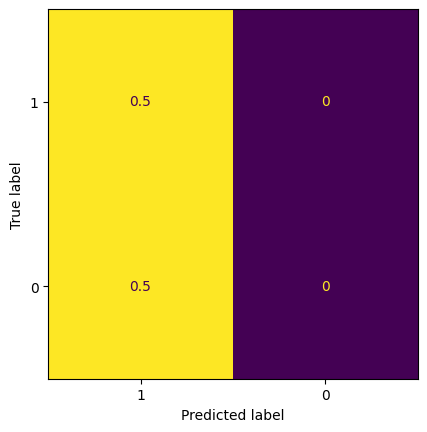

In [41]:
#Create confusion matrix
result2 = confusion_matrix(pred_labels_array, predicted_classes2 , normalize='pred', labels=[1,0] )

# display matrix
result_display2 = metrics.ConfusionMatrixDisplay(confusion_matrix = result2, display_labels = ["1", "0"])
result_display2.plot(colorbar = False)
plt.show()

**Results**

Model 2 performs just like our previous models, in that it simply predicts a single category each time, and again it predicts 1. As such, this model also has an accuracy of 0.5 and a Macro-F1 score of 0.333 when tested on the predicted sentences. Thus, this model performs as poorly as the previous ones.

This model is the one model of our's where bad performance is most likely, as it uses pooled embeddings which combine both the premise and hypothesis into a single embedding, such that the model may not have a way to actually learn the distinction in the first place.

### Model 3

Our last attempt was a simple LSTM model, which could be expected to perform at least better than the dense model, as it takes both lexical semantics and word order into account, so that it may be able to recognize the difference between two sentences. This is because the LSTM layer passes on both information about the previous output as well as some overall information. Here, we also attempted many modifications such as adding another LSTM layer or adding Dropout, but performance did not improve in a desired way.

In [42]:
# build LSTM model: 1 LSTM layer with 128 nodes
# input = (seq_length = 32, vector_size = 768)
model_03 = Sequential(name='Model_03')
model_03.add(layers.LSTM(128, input_shape=(32, 768)))
model_03.add(layers.Dense(32, activation='relu'))
model_03.add(layers.Dense(1, activation='sigmoid'))


# compile model with adam optimizer and binary crossentropy loss
model_03.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_03.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "Model_03"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │       459,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 463,425 (1.77 MB)

 Trainable params: 463,425 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# train model using the established sequential training set, with 10% used for validation
# parameters: 20 epochs, batches of 64
with tf.device('/device:GPU:1'):
    history_03 = model_03.fit(x_train_03, y_train_03,
                        epochs=20,
                        batch_size=64,
                        validation_split=0.1)

Epoch 1/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.5052 - loss: 0.6957 - val_accuracy: 0.5238 - val_loss: 0.6924
Epoch 2/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5135 - loss: 0.6924 - val_accuracy: 0.5242 - val_loss: 0.6922
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5191 - loss: 0.6919 - val_accuracy: 0.5004 - val_loss: 0.6934
Epoch 4/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5243 - loss: 0.6911 - val_accuracy: 0.5132 - val_loss: 0.6929
Epoch 5/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5333 - loss: 0.6874 - val_accuracy: 0.5064 - val_loss: 0.6936
Epoch 6/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5594 - loss: 0.6803 - val_accuracy: 0.5126 - val_loss: 0.7019
Epoch 7/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5845 - loss: 0.6655 - val_accuracy: 0.5186 - val_loss: 0.7170
Epoch 8/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6237 - loss: 0.6383 - val_accuracy: 

**Evaluation on the Test Set**

In [44]:
# evaluate on test set
test_ev_03 = model_03.evaluate(x_test_03, y_test_03)

363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5024 - loss: 2.0811


**Plotting Accuracy and Loss**

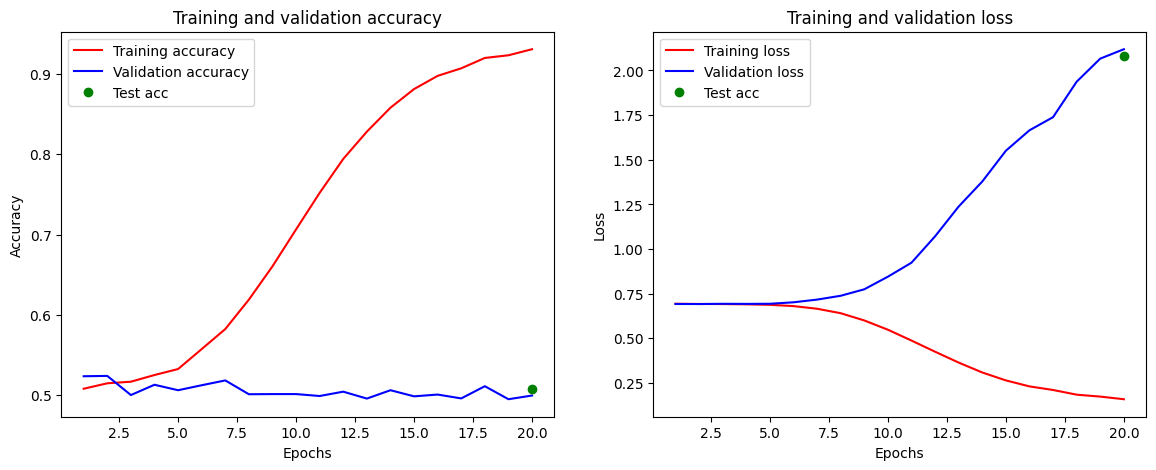

In [45]:
# use plot function
plot_training_history(history_03, test_ev_03)

**Predictions**

In [46]:
# make predictions
pred_predictions3 = model_03.predict(x_pred_03)


# get predicted class based on probality
predicted_classes3 = [1 if prob[0] >= 0.5 else 0 for prob in pred_predictions3]
predicted_classes3_array = np.array(predicted_classes3)

# print target and predicted lables
print(pred_labels_array)
print(predicted_classes3_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
[1 0 0 1 1 1 1 1 1 0 0 0 1 0 0 1 1 0 1 1]


**Classification Report**

In [47]:
# use evaluation function
evaluate_classification(pred_labels, predicted_classes3)

Accuracy: 0.6000
Macro-F1 Score: 0.5960
---------------------------------
Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.50      0.56        10
           1       0.58      0.70      0.64        10

    accuracy                           0.60        20
   macro avg       0.60      0.60      0.60        20
weighted avg       0.60      0.60      0.60        20



**Confusion** **matrix**

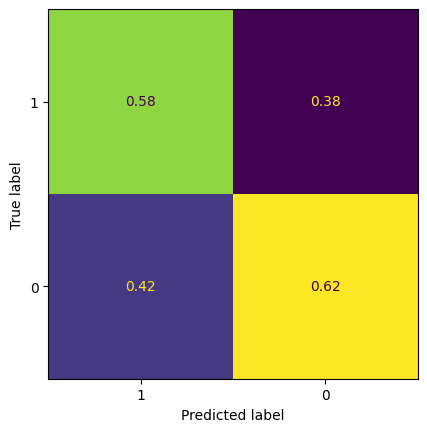

In [48]:
#Create confusion matrix
result3 = confusion_matrix(pred_labels_array, predicted_classes3_array , normalize='pred', labels=[1,0] )

# display matrix
result_display3 = metrics.ConfusionMatrixDisplay(confusion_matrix = result3, display_labels = ["1", "0"])
result_display3.plot(colorbar = False)
plt.show()

**Results**

This model performs quite differently to the other models, in that it actually  makes different predictions instead of just guessing the same lable each time. However, plotting the training accuracy shows that the model is actively overfitting, performing increasingly well on the training data, but at chance on the validation and test data. Our attempts to fix this, as outlined before, where not sucessfull. 

When looking at the classification report, we can see that the model has a slightly lower precision but much higher recall on lable 1, when compared to label 0. This could be because the model generally predicts label 1 more often than label 0, which is in line with there being slightly more data labled as 1 overall. If this is the case and assuming the model tags unseen data at chance, the model would then perform at chance when tagging sentences as positive rather than negative (precision) but overall guess more positive sentences correctly (recall). 

Overall, the model has a higher classification accuracy (0.6) and Macro-F1 score (0.5960) than the other models. However, the model seems to not "learn" the pattern, but rather memorize the training set and then randomly guess labels for any other input. Thereby, the model performance is simply more varied, but not significantly different to that of the other models.


# Final evaluation

In summary, none of our models performed very well on predicting whether the second sentence in a sentence pair was a negated or paraphrased version of the first sentence. 

Below are the confusion matrices for each model, as well as a table summarizing each model's predictions on the ten prediction sentences. The first five of these were antonym-negation and the second five negation using "not" or "n't". Most models only predict a single label, so their performance did not differ between the two types of negation. Model 3, seemed to perform slightly better on verbal negation, predicting 4/5 correct and only 3/5 for antonyms. The model also seems to predict label 1 correctly more often than label 0, which is seen in the higher recally. However, we have seen that the model overfits, making further predictions at chance and based on the slight discrepancy in label distribution. 

There are two likely causes for the observed performance. The simple explanation is that negation is simply a hard task for language models, as has been seen in previous research (Truong et al, 2023). Especially antonym style negation can be difficult, as it relies on the words being very similar in some regards but different in others (eg. opposite ends of the same scale).

Another issue might be the difficulty in the provided dataset. Not only do the sentences themselves often consist of unique words and complex topics, but the complexity and type of negation also varies. Thus, our models must capture a lot of different types of information and it is likely that our models are simply to simplistic and the training data much too small to account for this.

Overall, our models performed badly, but this was not unexpected.

**Confusion Matrices of all Models**

<Figure size 640x480 with 0 Axes>

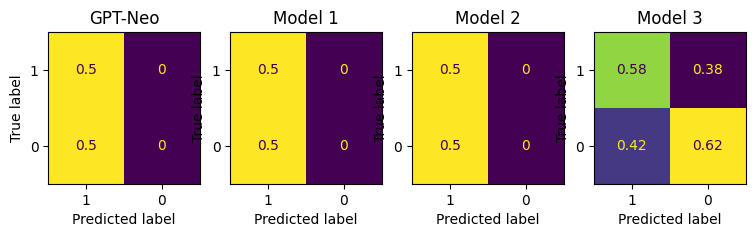

In [49]:
plt.clf()

# plot the confusion matrices for all four models in one line
fig = plt.figure(figsize=(9, 4)) #figsize=(10, 6)

sp1 = plt.subplot(1, 4, 1)
result_display.plot(ax=sp1)
plt.gca().images[-1].colorbar.remove() # removes the colorbar
plt.title("GPT-Neo")


sp1 = plt.subplot(1, 4, 2)
result_display1.plot(ax=sp1)
plt.gca().images[-1].colorbar.remove()
plt.title("Model 1")


sp2 = plt.subplot(1, 4, 3)
result_display2.plot(ax=sp2)
plt.gca().images[-1].colorbar.remove()
plt.title("Model 2")


sp3 = plt.subplot(1, 4, 4)
result_display3.plot(ax=sp3)
plt.gca().images[-1].colorbar.remove()
plt.title("Model 3")

plt.show()

**Table of predictions made by all models**

In [50]:
# create dictionary: prediction sentences and the predcitions from each model
table_df = {
    # manual indice column to apply color to it
    " ": [i for i in range(20)],
    "Premise": dataset.loc[[i for i in pred_rows], "premise"],
    "Hypothesis": dataset.loc[[i for i in pred_rows], "hypothesis"],
    "Actual Labels": dataset.loc[[i for i in pred_rows], "label"],
    "Predicted Labels GPT": gpt_pred,
    "Predicted Labels Model 1": predicted_classes1,
    "Predicted Labels Model 2": predicted_classes2,
    "Predicted Labels Model 3": predicted_classes3  
}

# make the dictionary a dataframe with indices 0-19 ????
df = pd.DataFrame(table_df).reset_index(drop=True)

# highlight manual indice column based on sentence type
def highlighter(cell_value):
    if cell_value < 5:
        return 'background-color: plum'
    elif cell_value < 10:
        return 'background-color: lightblue'
    elif cell_value < 20:
        return 'background-color: lightgreen'
    else:
        return ''

# apply color function and hide inbuilt index column, then display
pretty_df = df.style.map(highlighter, subset=[" "]).hide(axis="index")
display(pretty_df)

,Premise,Hypothesis,Actual Labels,Predicted Labels GPT,Predicted Labels Model 1,Predicted Labels Model 2,Predicted Labels Model 3
0,That's a good idea.,That's an evil idea.,1,1,1,1,1
1,There's something that's not right.,There's something that's not incorrect.,1,1,1,1,0
2,He would die before this work was complete.,He would die after this work was complete.,1,1,1,1,0
3,It has a high gable roof and marble end chimneys.,It has a low gable roof and brick end chimneys.,1,1,1,1,1
4,She often uses deliberately unrealistic characters in her work such as simplified archetypes.,She never make use of deliberately unrealistic characters in her work such as simplified archetypes.,1,1,1,1,1
5,She didn't leave.,She left.,1,1,1,1,1
6,"Its foundations are not Gravel Point, Charlevoix Limestone, Petoskey, and Whiskey Creek.","Its formations are Gravel Point, Charlevoix Limestone, Petoskey, and Whiskey Creek.",1,1,1,1,1
7,"Looks good in the picture, but this case wasn't a huge disappointment!!","Looks good in the picture, but this case was a huge disappointment!!",1,1,1,1,1
8,"It doesn't work great with a car charger, especially if you cannot plug in two adapters at the same time.","It works great with a car charger, especially if you cannot plug in two adapters at the same time.",1,1,1,1,1
9,External corrosion was not suspected at all.,External corrosion was suspected.,1,1,1,1,0


# Sources


Anschütz, M., Lozano, D. M., & Groh, G. (2023). This is not correct! negation-aware evaluation of language generation systems. <i>arXiv preprint arXiv:2307.13989</i>.

Gao, L., Biderman, S., Black, S., Golding, L., Hoppe, T., Foster, C., ... & Leahy, C. (2020). The pile: An 800gb dataset of diverse text for language modeling. <i>arXiv preprint arXiv:2101.00027.</i>

Truong, T. H., Baldwin, T., Verspoor, K., & Cohn, T. (2023). Language models are not naysayers: an analysis of language models on negation benchmarks. <i>arXiv preprint arXiv:2306.08189</i>.


Mishra, A. (2023, February 25). Keras documentation: Semantic Similarity with KerasNLP. https://keras.io/examples/nlp/semantic_similarity_with_keras_nlp/



